# MIMIC-III Sepsis Feature Probe

There are many possible features and markers that could indicate the survivability of a patient with suspected sepsis. In this notebook I will probe and visualize the suspected features of import. I will conduct several techniques to select features and trim less significant ones using univariate analysis and other techniques.

Note that the dataset in its entirety has been set up locally on a Postgresql database. All machine learning will be done remotely to save time and resources down the road.

In [91]:
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
import pandas as pd
from sklearn import preprocessing

import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [2]:
# Set up SQL Alchemy engine and session
Base = automap_base()

# Doing basic probes on data locally
engine = create_engine("postgresql://mimic_user@localhost:5432/mimic")

# Reflect the tables
Base.prepare(engine, reflect=True, schema='mimiciii')

# mapped classes are now created with names by default
# matching that of the table name.
Admission = Base.classes.admissions
Patient = Base.classes.patients

session = Session(engine)

In [9]:
# session.query(User.name.label('name_label')).all()
# admission_query = session.query(Admission)
admission_query = session.query(Admission).filter_by(diagnosis='SEPSIS')
#  User.query.filter_by(username='peter').first()
df = pd.read_sql(admission_query.statement, admission_query.session.bind)

df.head()
# admission_type, hospital_expire_flag

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,458,357,122609,2198-11-01 22:36:00,2198-11-14 14:20:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,2198-11-01 18:01:00,2198-11-01 23:06:00,SEPSIS,0,1
1,471,366,134462,2164-11-18 20:27:00,2164-11-22 15:18:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,SINGLE,HISPANIC OR LATINO,2164-11-18 10:52:00,2164-11-18 21:31:00,SEPSIS,0,1
2,96,94,183686,2176-02-25 16:49:00,2176-02-29 17:45:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,CANT,NOT SPECIFIED,MARRIED,ASIAN,2176-02-25 10:35:00,2176-02-25 18:14:00,SEPSIS,0,1
3,20,21,111970,2135-01-30 20:50:00,2135-02-08 02:08:00,2135-02-08 02:08:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,JEWISH,MARRIED,WHITE,2135-01-30 18:46:00,2135-01-30 22:05:00,SEPSIS,1,1
4,448,353,108923,2151-03-28 16:01:00,2151-04-13 16:10:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,PTUN,JEWISH,SINGLE,WHITE,2151-03-28 13:02:00,2151-03-28 17:46:00,SEPSIS,0,1


In [37]:
def period(row, period):
    
    if row['deathtime'] == None:
        return 0
    elif row['deathtime'] - row['admittime'] > period:
        return 0
    else:
        return 1
    row['admittime']

In [40]:
df['death_period'] = df.apply (lambda row: period (row, pd.Timedelta('30 days')),axis=1)

In [61]:
adm_col = ['subject_id', 'hadm_id', 'admittime', 'admission_type', 'insurance', 'ethnicity', 'death_period']
admissions = df[adm_col]

In [62]:
# Obtain patient information and trim unnecessary information
patient_query = session.query(Patient)
patients = pd.read_sql(patient_query.statement, patient_query.session.bind)
patients = patients[['subject_id', 'gender', 'dob']]

In [63]:
# Join patients and admission dataframes to obtain gender and age of patient
patient_info = admissions.join(patients.set_index('subject_id'), on='subject_id')

In [76]:
def age(row):
    possible_age = int((row['admittime'] - row['dob'])/pd.Timedelta('365 days'))
    if possible_age < 0:
        
    return int((row['admittime'] - row['dob'])/pd.Timedelta('365 days'))

In [77]:
patient_info['age'] = patient_info.apply (lambda row: age (row),axis=1)

In [78]:
patient_info.head()

,subject_id,hadm_id,admittime,admission_type,insurance,ethnicity,death_period,gender,dob,age
0,357,122609,2198-11-01 22:36:00,EMERGENCY,Private,WHITE,0,M,2135-03-22,63
1,366,134462,2164-11-18 20:27:00,EMERGENCY,Medicare,HISPANIC OR LATINO,0,M,2112-05-22,52
2,94,183686,2176-02-25 16:49:00,EMERGENCY,Medicare,ASIAN,0,M,2101-09-20,74
3,21,111970,2135-01-30 20:50:00,EMERGENCY,Medicare,WHITE,1,M,2047-04-04,87
4,353,108923,2151-03-28 16:01:00,EMERGENCY,Medicare,WHITE,0,M,2089-07-23,61


## Analyzing the Importance of Basic Patient Information

The admission table has been trimmed and a period of importance for mortality computed. The patient information table has been trimmed and joined to the modified admission table. It is now possible to look into several different potentially useful details regarding patient mortality.

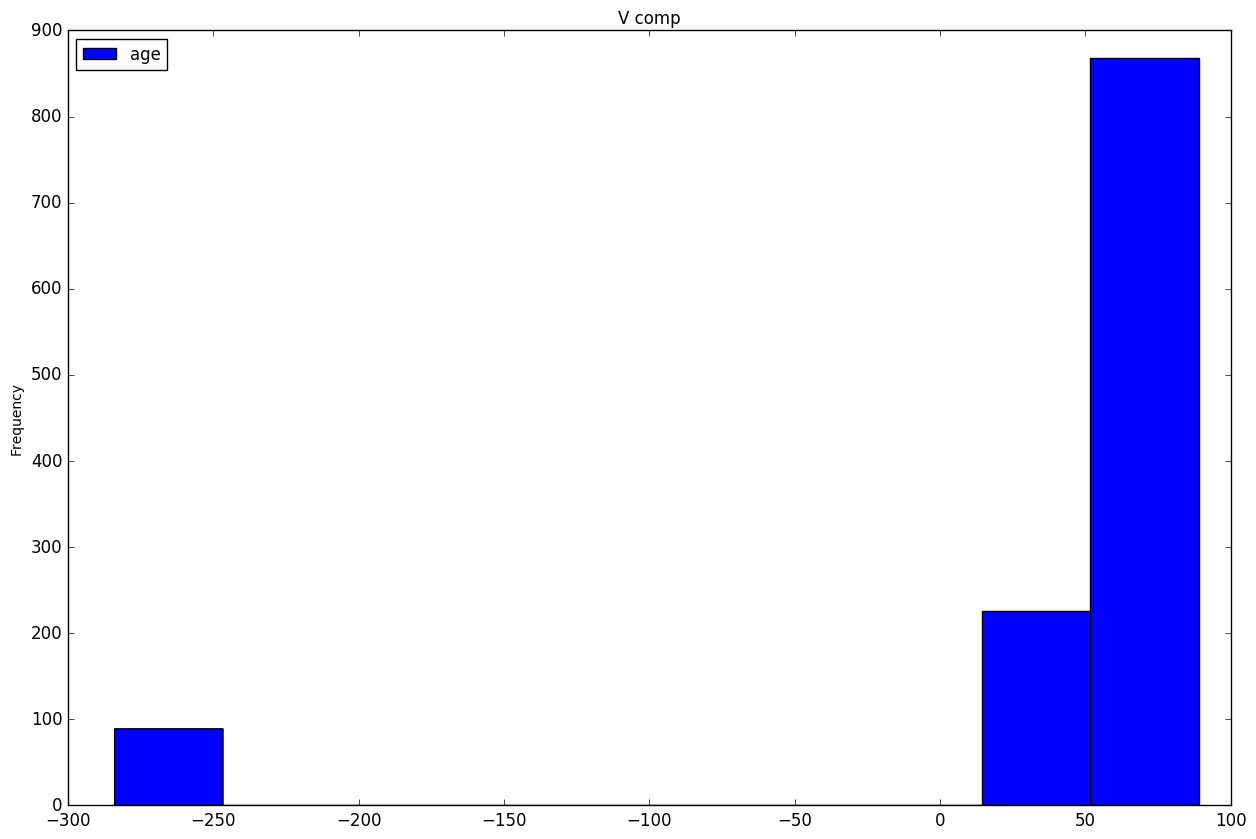

In [81]:
ax = patient_info[['age']].plot(kind='hist', title ="V comp", figsize=(15, 10), legend=True, fontsize=12)

In [83]:
patient_info

,subject_id,hadm_id,admittime,admission_type,insurance,ethnicity,death_period,gender,dob,age
0,357,122609,2198-11-01 22:36:00,EMERGENCY,Private,WHITE,0,M,2135-03-22,63
1,366,134462,2164-11-18 20:27:00,EMERGENCY,Medicare,HISPANIC OR LATINO,0,M,2112-05-22,52
2,94,183686,2176-02-25 16:49:00,EMERGENCY,Medicare,ASIAN,0,M,2101-09-20,74
3,21,111970,2135-01-30 20:50:00,EMERGENCY,Medicare,WHITE,1,M,2047-04-04,87
4,353,108923,2151-03-28 16:01:00,EMERGENCY,Medicare,WHITE,0,M,2089-07-23,61
5,353,131488,2151-10-01 20:42:00,EMERGENCY,Medicare,WHITE,0,M,2089-07-23,62
6,507,148905,2146-06-22 00:58:00,EMERGENCY,Medicare,WHITE,0,M,2071-03-06,75
7,406,113900,2119-08-25 22:37:00,EMERGENCY,Medicaid,WHITE,0,F,2058-01-29,61
8,406,171178,2120-09-17 05:03:00,EMERGENCY,Medicaid,WHITE,0,F,2058-01-29,62
9,406,100765,2126-03-11 23:06:00,EMERGENCY,Medicare,WHITE,0,F,2058-01-29,68


In [109]:
p1 = patient_info.loc[patient_info['subject_id'] == 166]

In [110]:
p1

,subject_id,hadm_id,admittime,admission_type,insurance,ethnicity,death_period,gender,dob,age
11,166,128219,2105-01-23 22:57:00,EMERGENCY,Medicare,WHITE,1,F,1805-01-23 00:00:00,-284


In [123]:
# print datetime.datetime(p1['dob'].values[0])
print pd.to_datetime(p1['dob'].values[0])
print'test'
print type(p1['admittime'].values[0])
# datetime.datetime(p1['admittime'])
# - p1['dob']

1805-01-23 00:00:00
test
<type 'numpy.datetime64'>


In [119]:
int((p1['admittime'] - p1['dob'])/pd.Timedelta('365 days'))
p1['dob'] + pd.Timedelta('109500 days')

OverflowError: Python int too large to convert to C long